<a href="https://colab.research.google.com/github/ahvblackwelltech/DS-Unit-4-Sprint-1-NLP/blob/main/module1-text-data/Ahvi_Blackwell_LS_DS_421_Text_Data_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

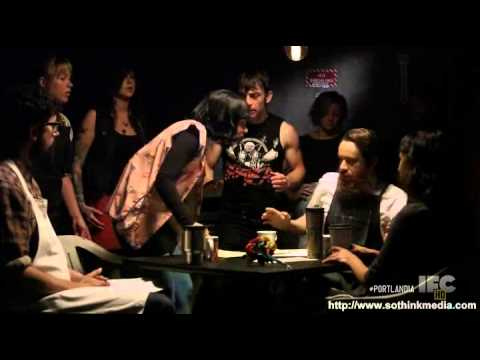

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'/content'

In [5]:
import pandas as pd
import re
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import spacy.cli
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

spacy.cli.download('en_core_web_lg')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [6]:
url = 'https://raw.githubusercontent.com/ahvblackwelltech/DS-Unit-4-Sprint-1-NLP/main/module1-text-data/data/yelp_coffeeshop_review_data.csv'

df = pd.read_csv(url)
df.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [7]:
df['full_review_text'].value_counts(normalize=True)[:2]

 10/30/2016 1 check-in Super cute place for lounging and chatting up with a friend. The chicken and waffle was delicious. Chicken was cooked to perfection! Super moist chicken with fluffy waffle...more of a snack than a meal, so don't go here expecting to be filled with a meal.                                                                                                             0.000525
 11/25/2016 Very cool decor! Good drinks Nice seating  However...  Just about everything is overpriced. $1.50 extra for 3 ounces of Almond Milk in a cortado. No WiFi Music is a bit loud and the mix is odd.  Pleasant French oldies followed by loud techno. Several tables were dirty when we got there. Service is average.  It feels like a Los Angeles coffee shot that is out of place.     0.000525
Name: full_review_text, dtype: float64

In [8]:
# Checking how many rows and columns
df.shape

(7616, 3)

In [9]:
# Clean up star_rating 
df['star_rating'] = df['star_rating'].str.replace('.0 star rating', '')
print(df['star_rating'].head())

0     5 
1     4 
2     4 
3     2 
4     4 
Name: star_rating, dtype: object


## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [10]:
# Coverting star_rating into a float
df['star_rating'] = df['star_rating'].apply(pd.to_numeric)

In [11]:
# Creating revised column for star_rating
df['good_or_bad'] = df['star_rating'].apply(lambda x: 'good' if x <= 4 else 'bad')
print(df['good_or_bad'].head())

0     bad
1    good
2    good
3    good
4    good
Name: good_or_bad, dtype: object


In [12]:
# Creating revised column from full_review_text column
df['date'] = df['full_review_text'].str.extract('(../.?./....)', expand=True)
print(df['date'])

0       11/25/2016
1        12/2/2016
2       11/30/2016
3       11/25/2016
4        12/3/2016
           ...    
7611     2/19/2015
7612     1/21/2016
7613     4/30/2015
7614      8/2/2015
7615     5/23/2015
Name: date, Length: 7616, dtype: object


In [13]:
# Removing the dates from the full_review_text column
df['full_review_text'] = df['full_review_text'].str.replace('(../.?./....)', '')

In [14]:
# Checking df 
df.head()

,coffee_shop_name,full_review_text,star_rating,good_or_bad,date
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! E...,5,bad,11/25/2016
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Au...",4,good,12/2/2016
2,The Factory - Cafe With a Soul,1 check-in Listed in Brunch Spots I loved th...,4,good,11/30/2016
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice seating H...,2,good,11/25/2016
4,The Factory - Cafe With a Soul,1 check-in They are located within the North...,4,good,12/3/2016


In [15]:
# Checking full_review_text for grammar errors
df['full_review_text'].value_counts()

  AMAZING atmosphere! I walked around for 5 minutes looking at everything before even ordering.  Most unique take on chicken and waffles I've ever had. Hands down best night time hangout in North Austin. P.S.... their Matcha Latte is to die for!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [16]:
# Coverting the text in full_review_text into lowercase 
df['full_review_text'] = df['full_review_text'].apply(lambda x: x.lower())
df['full_review_text'].value_counts()

  really love the atmosphere here! i frequent coffee shops and this one is definitely unique and worth checking out.  pros: great atmosphere friendly staff good hangout/ study environment beautiful lighting tasty drinks  cons: no wifi slightly pricey pretty things love all the details here. it just has good vibes. definitely the perfect cafe atmosphere. see all photos from sierra l. for the factory - cafe with a soul                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [17]:
# Creating A Tokenize Function
def tokenize(text):
    """Parses a string into a list of semantic units (words)

    Args:
        text (str): The string that the function will tokenize.

    Returns:
        list: tokens parsed out by the mechanics of your choice
    """
    tokens = re.sub(r'[^a-zA-Z ^0-9]', '', text)
    tokens = tokens.lower().split()

    return tokens

In [21]:
# Tokenize the text in full_review_text column to a token column
df['tokens'] = df['full_review_text'].apply(tokenize)

In [22]:
# View token column
df['tokens'].head()

0    [1, checkin, love, love, loved, the, atmospher...
1    [listed, in, date, night, austin, ambiance, in...
2    [1, checkin, listed, in, brunch, spots, i, lov...
3    [very, cool, decor, good, drinks, nice, seatin...
4    [1, checkin, they, are, located, within, the, ...
Name: tokens, dtype: object

In [24]:
from collections import Counter

word_count = Counter()

df['tokens'].apply(lambda x: word_count.update(x))

word_count.most_common(10)

[('the', 34809),
 ('and', 26650),
 ('a', 22755),
 ('i', 20237),
 ('to', 17164),
 ('of', 12597),
 ('is', 11999),
 ('coffee', 10353),
 ('was', 9707),
 ('in', 9546)]

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

